### Для запуска в googlecolab

In [1]:
import os

try:
    from google.colab import files as google_files
    RUNNING_IN_COLAB = True
except ImportError:
    google_files = None
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    os.system('git clone https://github.com/vekshinnikita/face_recognition.git /content/face_recognition')
    os.chdir('/content/face_recognition') 

In [1]:
from tqdm import tqdm
import os
from typing import Iterable
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from utils.model import generate_sequence, save_model
from torchvision.transforms import v2

from utils.transform import reverse_transform_decorator
from utils.display import show_image_with_bboxes
from utils.model import calc_metrics, calc_batch_metrics
from utils.iou import iou
from utils.system import delete_files_with_prefix
from models.simple_decoder import SimpleFaceDetector, info_string as model_info_string
from dataset_classes.vgg_face2_detector import VGGFace2DetectorDataset

In [2]:
device = 'cude' if torch.cuda.is_available() else 'cpu'

In [3]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = './best_models/best_simple_decoder_04-06_12:31_epoch_1.pt' # Путь к сохраненному файлу с параметрами

SAVE_BEST_DIR_PATH = './best_models/'
SAVE_BEST_FILE_NAME = 'best_simple_decoder_{start_datetime:%m-%d_%H:%M}_epoch_{epoch}.pt'

EPOCHS = 20


In [4]:
SAVE_BEST_FILE_PATH = os.path.join(SAVE_BEST_DIR_PATH, SAVE_BEST_FILE_NAME)

def is_train():
    return MODE == 'train'

def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE)

In [5]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((256, 256)),  # Измените размер под вашу модель
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor, new_image_size: Iterable):
    new_height, new_width = new_image_size
    
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
        v2.Resize((new_height, new_width)),  # Возвращаем к исходному размеру
    ])
    
    return fn(image)

if is_train():
    dataset = VGGFace2DetectorDataset(
        './dataset/images/test',
        './dataset/labels/test',
        transform,
        reverse_transform
    )
    
print(len(dataset))

# test_data = VGGFace2DetectorDataset(
#     './dataset/images/val',
#     './dataset/labels/test/labels'
# )

216909


In [6]:
if is_train():
    train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

    batch_size = 64

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
model = SimpleFaceDetector().to(device)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])


## Проверка модели

Уверенность наличия лица:  0.00, tensor([0.])
IoU равна: 0.0
tensor([0., 0., 0., 0.]) tensor([1., 1., 2., 1.])


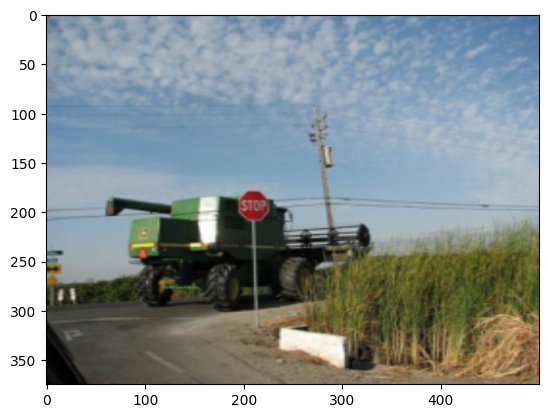

In [8]:
if is_train():
    image, bbox, confidence, original_image_size = dataset[70323]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )

    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи

    predict_bbox, predict_confidence = model.forward(data)
    predict_bbox = predict_bbox[0]
    predict_confidence = predict_confidence[0]
    
    iou_value = iou(predict_bbox, bbox)
    
    print(f'Уверенность наличия лица: {predict_confidence.item(): .2f}, {confidence}')
    print(f'IoU равна: {iou_value}')

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    print(bbox, predict_bbox)
    show_image_with_bboxes(original_image, [bbox, predict_bbox])


In [9]:
# Выбор функции потерь

if is_train():
    loss_bbox_model = nn.MSELoss()
    loss_confidence_model = nn.BCELoss()
    
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, # оптимизатор.
        mode= 'min', # 'max' или 'min" - следим, чтобы отслеживаемый параметр увеличивался (*!
        factor=0.1, # коэффициент, на который будет умножен lr
        patience=2, # кол-во.эпох без улучшения отслеживаемого параметра.
    )
    
    if is_load_from_saved():
        opt.load_state_dict(load_parameters['state_opt'])
        lr_scheduler.load_state_dict(load_parameters['state_lr_scheduler'])

In [10]:

if is_train():
    start_from_epoch = 0
    
    train_loss = []
    train_precision = []
    train_recall = []
    train_f1 = []
    train_iou_avg = []
    val_loss = []
    val_recall = []
    val_f1 = []
    val_precision = []
    val_iou_avg = []

    lr_list = []
    best_loss = None
    
    if is_load_from_saved():
        # EPOCHS = load_parameters['epoch']['EPOCHS']
        start_from_epoch = load_parameters['epoch']['save_epoch']
        
        train_loss = load_parameters['loss']['train_loss']
        val_loss = load_parameters['loss']['val_loss']
        best_loss = load_parameters['loss']['best_loss']
        
        train_precision = load_parameters['metric']['train_precision']
        val_precision = load_parameters['metric']['val_precision']
        train_recall = load_parameters['metric']['train_recall']
        train_f1 = load_parameters['metric']['train_f1']
        val_recall = load_parameters['metric']['val_recall']
        val_f1 = load_parameters['metric']['val_f1']
        train_iou_avg = load_parameters['metric']['train_iou_avg']
        val_iou_avg = load_parameters['metric']['val_iou_avg']
        lr_list = load_parameters['lr_list']
        

In [11]:
start_datetime = datetime.now()

if is_train():
    threshold = 0.1
    saved_epoch = None
    # Цикл обучения
    
    for epoch in range(start_from_epoch, EPOCHS):
        
        # Тренировка модели
        train_loop = tqdm(train_loader, leave=False)
        running_train_loss = []
        
        metrics_var_list = None
        
        model.train()
        for x, target_bbox, target_confidence, _ in train_loop:

            # Прямой проход + расчет ошибки модели
            pred_bbox, pred_confidence = model(x)
            
            bbox_loss = loss_bbox_model(pred_bbox, target_bbox)
            confidence_loss = loss_confidence_model(pred_confidence, target_confidence)
            loss = bbox_loss + confidence_loss
            
            # Обратный проход
            opt.zero_grad()
            loss.backward()
            
            # Шаг оптимизации
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)
            
            var_batch_list = calc_batch_metrics(
                pred_bbox, 
                target_bbox,
                pred_confidence,
                target_confidence,
                iou_threshold=0.7
            )
            if metrics_var_list is None:
                metrics_var_list = var_batch_list.detach().numpy()
            else:
                metrics_var_list += var_batch_list.detach().numpy()
            
            train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}")
            
            # Расчет значения метрики  
            # Сохранение значения функции потерь и метрики
    
        
        r_train_precision, r_train_recall, r_train_f1, r_train_iou_avg = calc_metrics(*metrics_var_list)
        train_loss.append(mean_train_loss)
        train_precision.append(r_train_precision)
        train_recall.append(r_train_recall)
        train_f1.append(r_train_f1)
        train_iou_avg.append(r_train_iou_avg)
        
        # Проверка модели (валидация)
        running_val_loss = []
        metrics_var_list = None
        
        model.eval()
        with torch.no_grad():
            for x, target_bbox, target_confidence, _ in val_loader:
                
                # Прямой проход + расчет ошибки модели
                pred_bbox, pred_confidence = model(x)
                
                bbox_loss = loss_bbox_model(pred_bbox, target_bbox)
                confidence_loss = loss_confidence_model(pred_confidence, target_confidence)
                loss = bbox_loss + confidence_loss
                
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                var_batch_list = calc_batch_metrics(
                    pred_bbox, 
                    target_bbox,
                    pred_confidence,
                    target_confidence,
                    iou_threshold=0.7
                )
                if metrics_var_list is None:
                    metrics_var_list = var_batch_list.detach().numpy()
                else:
                    metrics_var_list += var_batch_list.detach().numpy()
                    
            r_val_precision, r_val_recall, r_val_f1, r_val_iou_avg = calc_metrics(*metrics_var_list)
            
            val_loss.append(mean_val_loss)
            val_precision.append(r_val_precision)
            val_recall.append(r_val_recall)
            val_f1.append(r_val_f1)
            val_iou_avg.append(r_val_iou_avg)
                
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        lr_list.append(lr)
        
        if best_loss is None:
            best_loss = mean_val_loss
        
        if mean_val_loss < best_loss - best_loss * threshold:
            best_loss = mean_val_loss
            
            # if saved_epoch is not None:
            #     prefix = SAVE_BEST_FILE_NAME.split('{start_datetime:%m-%d_%H:%M}')[0] + '{start_datetime:%m-%d_%H:%M}'
            #     delete_files_with_prefix(
            #         SAVE_BEST_DIR_PATH,
            #         prefix.format(start_datetime=start_datetime)
            #     )
            
            saved_epoch = epoch+1
            save_model(
                file_path=SAVE_BEST_FILE_PATH,
                str_info=model_info_string,
                model=model,
                start_datetime=start_datetime,
                opt=opt,
                lr_scheduler=lr_scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_loss=best_loss,
                train_precision=train_precision,
                train_iou_avg=train_iou_avg,
                train_recall=train_recall,
                train_f1=train_f1,
                val_recall=val_recall,
                val_f1=val_f1,
                val_iou_avg=val_iou_avg,
                val_precision=val_precision,
                lr_list=lr_list,
                EPOCHS=EPOCHS,
                epoch=epoch+1,
            )
            print(f'Ha эпoxe - {epoch+1}, сохранена модель со значением функции потерь на валидации - {mean_val_loss: 4f}', end='\n\n')

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}, train_precision={r_train_precision: .4f}, train_recall={r_train_recall: .4f}, train_f1={r_train_f1: .4f}, train_iou_avg={r_train_iou_avg: .4f}, val_loss={mean_val_loss: .4f}, val_precision={r_val_precision: .4f}, val_recall={r_val_recall: .4f}, val_f1={r_val_f1: .4f}, val_iou_avg={r_val_iou_avg: .4f}, lr={lr}")

KeyboardInterrupt: 

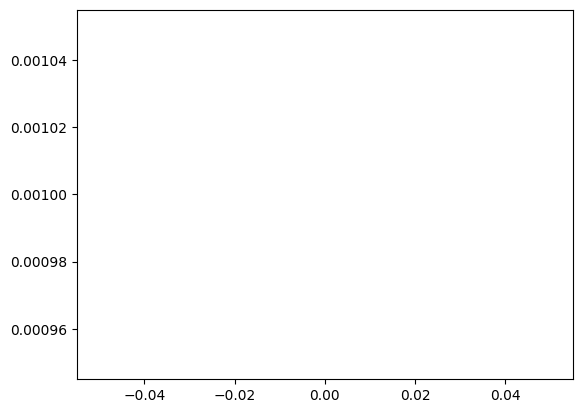

In [12]:
if is_train():
    plt.plot(lr_list)
    plt.show()

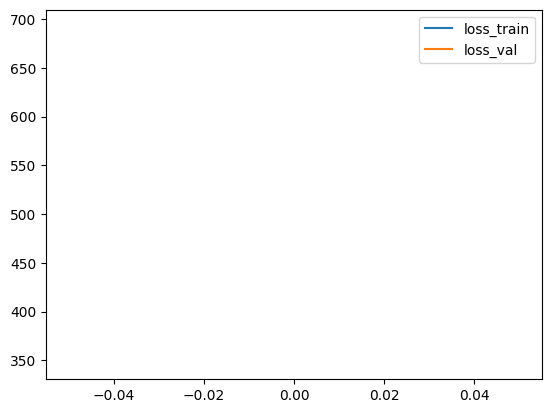

In [13]:
if is_train():
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['loss_train', 'loss_val'])
    plt.show()

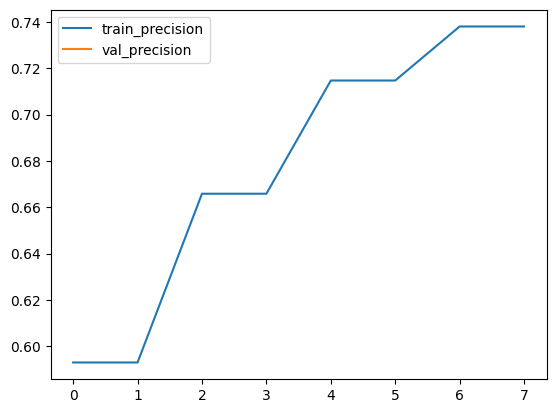

In [ ]:
if is_train():
    plt.plot(train_precision)
    plt.plot(val_precision)
    plt.legend(['train_precision', 'val_precision'])
    plt.show()

In [ ]:
if not is_train():
    image, bbox, confidence, original_image_size = dataset[405]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )

    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи

    predict_bbox = model.forward(data)[0]

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    show_image_with_bboxes(original_image, [predict_bbox])

ValueError: not enough values to unpack (expected 4, got 1)